In [1]:
##
import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] =  False

In [2]:
##
df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/nyc_energy_consumption.csv')
df.head(2)

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89


In [3]:
## make timestamp as dstetime object
df['timeStamp'] = pd.to_datetime(df['timeStamp'])
df.head(2)

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49205 entries, 0 to 49204
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timeStamp  49205 non-null  datetime64[ns]
 1   demand     49124 non-null  float64       
 2   precip     48975 non-null  float64       
 3   temp       49019 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 MB


In [5]:
##
df.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [6]:
##
fig = px.line(df, x = 'timeStamp', y = 'demand', title = 'NYC Energy Demand')
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list(
            [
             dict(count = 1, label = '1y', step = "year", stepmode = 'backward'),
             dict(count = 2, label = '3y', step = "year", stepmode = 'backward'),
             dict(count = 3, label = '5y', step = "year", stepmode = 'backward'),
             dict(step = "all"),
            ]
        )
    )
)

fig.show()

In [7]:
## set index
ny_df = df.set_index('timeStamp')
ny_df.head(2)

,demand,precip,temp
timeStamp,,,
2012-01-01 00:00:00,4937.5,0.0,46.13
2012-01-01 01:00:00,4752.1,0.0,45.89


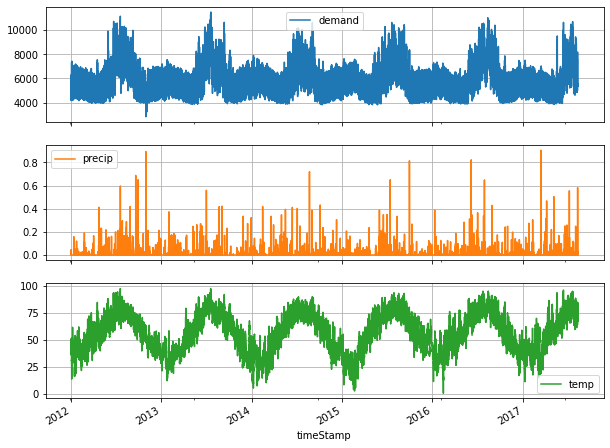

In [8]:
## plot
ny_df.plot(subplots=True, figsize=(10,8), grid = True);

In [9]:
print("Rows    : ", df.shape[0])
print("Columns : ", df.shape[1])
print("\nFeatures: \n", df.columns.tolist())
print("\nMissing Values:\n", df.isnull().any())
print("\nUnique values : \n", df.nunique())

Rows    :  49205
Columns :  4

Features: 
 ['timeStamp', 'demand', 'precip', 'temp']

Missing Values:
 timeStamp    False
demand        True
precip        True
temp          True
dtype: bool

Unique values : 
 timeStamp    49205
demand       40972
precip        1004
temp          7580
dtype: int64


                 demand    precip       temp
timeStamp                                   
2012-01-01  4954.833333  0.002487  46.510000
2012-01-02  5302.954167  0.000000  40.496667
2012-01-03  6095.512500  0.000000  26.672500
2012-01-04  6336.266667  0.000000  20.585000
2012-01-05  6130.245833  0.000000  33.577500
2012-01-06  5867.537500  0.000000  43.400833
2012-01-07  5177.441667  0.000000  51.497917
2012-01-08  5120.541667  0.000000  41.467083
2012-01-09  5890.820833  0.000000  35.360000
2012-01-10  5871.262500  0.000000  40.503333
                 demand    precip       temp
timeStamp                                   
2017-08-03  7672.781708  0.001262  75.489583
2017-08-04  7730.532292  0.003704  76.324167
2017-08-05  6657.496792  0.005629  74.172917
2017-08-06  5702.361542  0.000000  70.129167
2017-08-07  6398.154167  0.021233  68.203750
2017-08-08  6471.626042  0.000000  71.039167
2017-08-09  6811.112167  0.047529  73.852500
2017-08-10  5582.297000  0.002033  75.217500
2017-08-11

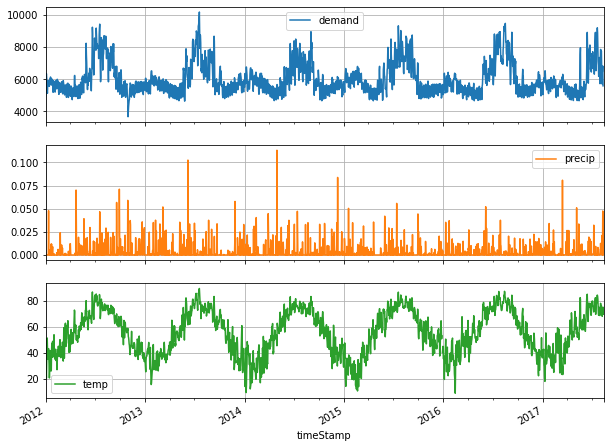

In [10]:
## Resample on month level
print(ny_df.resample('D').mean().head(10))
print(ny_df.resample('D').mean().tail(10))

## plot
ny_df.resample('D').mean().plot(subplots = True, grid=True, figsize=(10,8));

In [11]:
ny_df_daily = ny_df.resample("D").mean()

#### `Prophet Paper` : https://peerj.com/preprints/3190/

`Abstract`: "Forecasting is a common data science task that helps organizations with capacity planning, goal setting, and anomaly detection. Despite its importance, there are serious challenges associated with producing reliable and high quality forecasts — especially when there are a variety of time series and analysts with expertise in time series modeling are relatively rare. To address these challenges, we describe a practical approach to forecasting “at scale” that combines configurable models with analyst-in-the-loop performance analysis. We propose a modular regression model with interpretable parameters that can be intuitively adjusted by analysts with domain knowledge about the time series. We describe performance analyses to compare and evaluate forecasting procedures, and automatically flag forecasts for manual review and adjustment. Tools that help analysts to use their expertise most effectively enable reliable, practical forecasting of business time series."

$y(t) = g(t) + s(t) + h(t) + \epsilon_{t}$

where, <br>
$g(t)$ : trend function which models non-periodic changes in the value of the time  series <br>
$s(t)$ : periodic  changes  (e.g.,  weekly  and  yearly  seasonality) <br>
$h(t)$ :  the effects of holidays which occur on potentially irregular schedules overone or more days <br>
$e_{t}$ : error term


In [12]:
from fbprophet import Prophet

In [13]:
ny_df_final = ny_df_daily.reset_index()[['timeStamp', 'demand']].rename({'timeStamp':'ds', 'demand':'y'}, axis = 'columns')
display(ny_df_final.head(15))
display(ny_df_final.tail(15))

,ds,y
0,2012-01-01,4954.833333
1,2012-01-02,5302.954167
2,2012-01-03,6095.512500
3,2012-01-04,6336.266667
4,2012-01-05,6130.245833
5,2012-01-06,5867.537500
6,2012-01-07,5177.441667
7,2012-01-08,5120.541667
8,2012-01-09,5890.820833
9,2012-01-10,5871.262500


,ds,y
2036,2017-07-29,5921.470083
2037,2017-07-30,5713.357000
2038,2017-07-31,7146.220542
2039,2017-08-01,7838.961458
2040,2017-08-02,7807.786125
2041,2017-08-03,7672.781708
2042,2017-08-04,7730.532292
2043,2017-08-05,6657.496792
2044,2017-08-06,5702.361542
2045,2017-08-07,6398.154167


In [14]:
## training and testing dataset
train = ny_df_final[(ny_df_final['ds'] >= '2012-01-01') & (ny_df_final['ds'] <= '2017-04-30')]
test = ny_df_final[(ny_df_final['ds'] > '2017-04-30')]

print("Train dataset shape: ", train.shape)
print("Test dataset shape: ", test.shape)

Train dataset shape:  (1947, 2)
Test dataset shape:  (104, 2)


In [15]:
test.head(20)

,ds,y
1947,2017-05-01,5417.231583
1948,2017-05-02,5697.950042
1949,2017-05-03,5354.628500
1950,2017-05-04,5235.704833
1951,2017-05-05,5358.639500
1952,2017-05-06,4850.361500
1953,2017-05-07,4668.315958
1954,2017-05-08,5244.323958
1955,2017-05-09,5274.153125
1956,2017-05-10,5261.281125


In [16]:
## Model
m = Prophet(interval_width = 0.95, yearly_seasonality = True)
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [17]:
##
m.params

OrderedDict([('k', array([[0.08888412]])),
             ('m', array([[0.59346583]])),
             ('delta',
              array([[ 3.14928730e-08,  1.53741876e-07, -1.03044704e-01,
                      -2.11602996e-08,  1.40085597e-07,  1.81802026e-07,
                       1.43803423e-08, -6.11555343e-07,  6.49671582e-08,
                      -2.60011367e-07, -2.43433220e-02, -7.64404754e-02,
                      -2.03269748e-05, -1.67752062e-07,  2.37209776e-01,
                       3.72434388e-07, -1.02857630e-06, -8.82474336e-02,
                      -3.95645665e-02, -1.56344720e-08,  5.48404650e-08,
                       6.61535467e-08,  4.33979100e-03,  2.60526989e-03,
                       1.24238337e-07]])),
             ('sigma_obs', array([[0.04607601]])),
             ('beta',
              array([[-0.03458253, -0.07052008,  0.05760233,  0.04705168, -0.01407221,
                      -0.00500214, -0.00386595, -0.00073581,  0.00241974, -0.00755868,
                 

In [18]:
## 
future = m.make_future_dataframe(periods = 104) ## 104 size (rows) of test dataset
future.tail()

,ds
2046,2017-08-08
2047,2017-08-09
2048,2017-08-10
2049,2017-08-11
2050,2017-08-12


In [19]:
## Predictions
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2046,2017-08-08,7585.146506,6576.674403,8548.972903
2047,2017-08-09,7574.252310,6706.865840,8560.428878
2048,2017-08-10,7528.960519,6582.785356,8442.831159
2049,2017-08-11,7484.169113,6519.257464,8401.477129
2050,2017-08-12,6909.341600,6033.502910,7812.683278


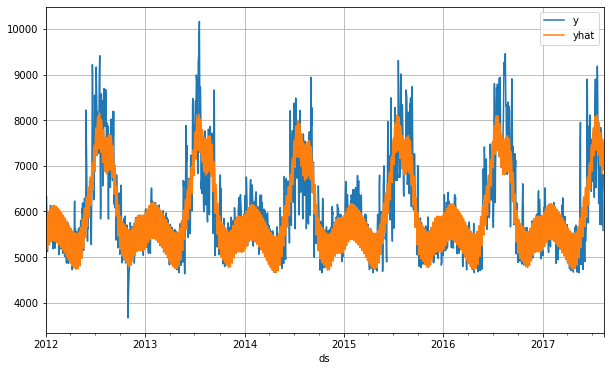

In [20]:
## Plot
pd.concat([ny_df_final.set_index('ds')['y'], forecast.set_index('ds')['yhat']], axis = 1).plot(figsize=(10, 6), grid = True);

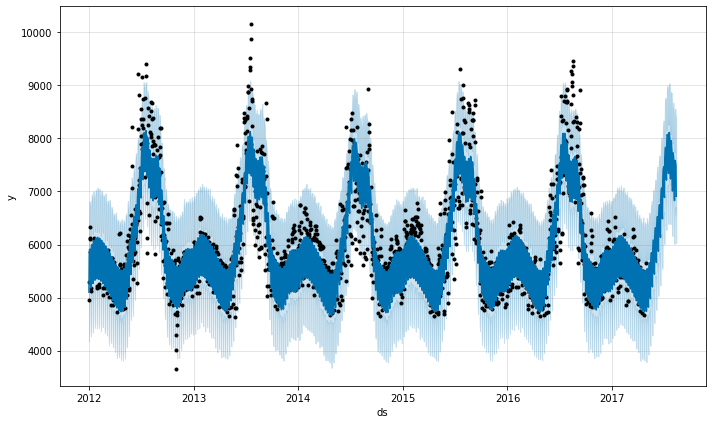

In [21]:
fig1 = m.plot(forecast)

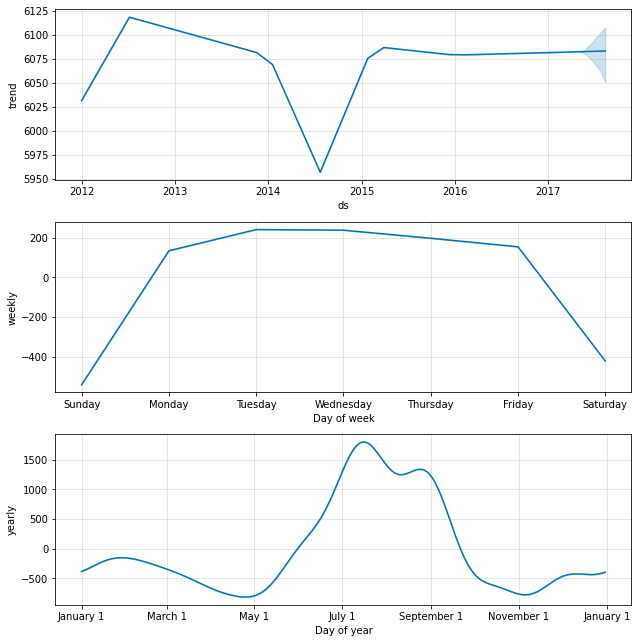

In [22]:
fig2 = m.plot_components(forecast)

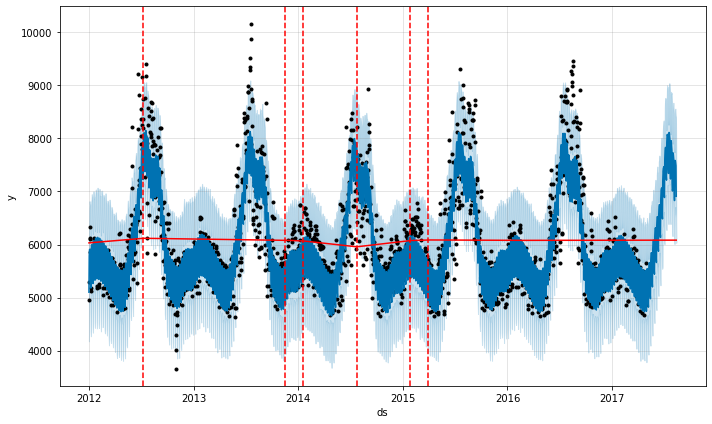

In [23]:
##
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [24]:
##
deltas = m.params['delta'].mean(0)
deltas

array([ 3.14928730e-08,  1.53741876e-07, -1.03044704e-01, -2.11602996e-08,
        1.40085597e-07,  1.81802026e-07,  1.43803423e-08, -6.11555343e-07,
        6.49671582e-08, -2.60011367e-07, -2.43433220e-02, -7.64404754e-02,
       -2.03269748e-05, -1.67752062e-07,  2.37209776e-01,  3.72434388e-07,
       -1.02857630e-06, -8.82474336e-02, -3.95645665e-02, -1.56344720e-08,
        5.48404650e-08,  6.61535467e-08,  4.33979100e-03,  2.60526989e-03,
        1.24238337e-07])

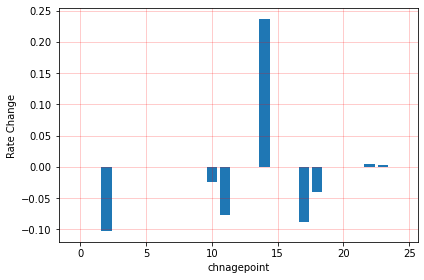

In [25]:
##
fig = plt.figure(facecolor = 'w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which = 'major', c = 'red', ls = '-', lw=1, alpha = 0.2)
ax.set_ylabel("Rate Change")
ax.set_xlabel("chnagepoint")
fig.tight_layout()

In [26]:
##
m.changepoints

62     2012-03-03
124    2012-05-04
187    2012-07-06
249    2012-09-06
311    2012-11-07
373    2013-01-08
436    2013-03-12
498    2013-05-13
560    2013-07-14
622    2013-09-14
685    2013-11-16
747    2014-01-17
809    2014-03-20
871    2014-05-21
934    2014-07-23
996    2014-09-23
1058   2014-11-24
1120   2015-01-25
1183   2015-03-29
1245   2015-05-30
1307   2015-07-31
1369   2015-10-01
1432   2015-12-03
1494   2016-02-03
1556   2016-04-05
Name: ds, dtype: datetime64[ns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


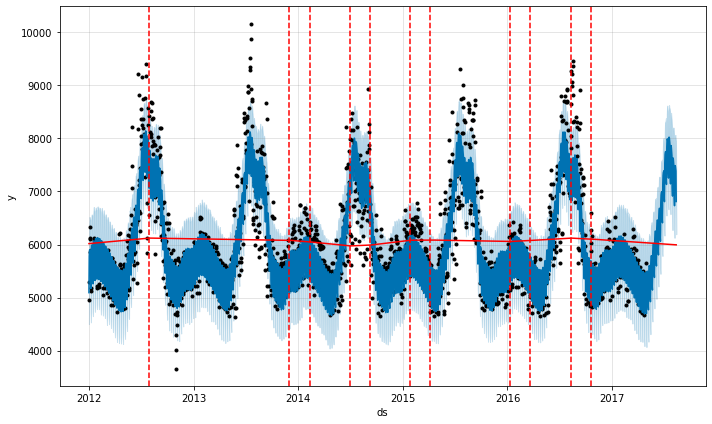

In [27]:
##
pro_change = Prophet(changepoint_range = 0.9, yearly_seasonality = True)
forecast = pro_change.fit(train).predict(future)
fig = pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [28]:
##
from fbprophet.plot import plot_plotly
import plotly.offline as py

fig = plot_plotly(m, forecast) # This returns a plotly figure
py.iplot(fig)

In [29]:
from fbprophet.diagnostics import cross_validation
cv_results = cross_validation(model = m, initial = '713 days', horizon = '365 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-05-01 00:00:00 and 2016-04-30 00:00:00


In [30]:
cv_results.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-05-02,5560.399158,4746.093232,6406.355393,5460.325000,2014-05-01
1,2014-05-03,4970.368653,4056.295513,5710.959993,4893.683333,2014-05-01
2,2014-05-04,4846.526492,4062.092046,5706.114110,4764.137500,2014-05-01
3,2014-05-05,5527.405000,4689.244572,6313.692693,5406.762500,2014-05-01
4,2014-05-06,5622.303858,4755.717447,6456.978228,5409.750000,2014-05-01


In [31]:
##
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(cv_results)
df_p.head(15)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days 12:00:00,251429.065746,501.427029,405.741907,0.072931,0.065579,0.890110
1,37 days 00:00:00,258154.308609,508.088879,413.132705,0.074218,0.066087,0.884615
2,37 days 12:00:00,260458.355734,510.351208,416.504551,0.074798,0.066775,0.884615
3,38 days 00:00:00,263245.456254,513.074513,419.608202,0.075062,0.067182,0.884615
4,38 days 12:00:00,266934.102525,516.656658,424.824052,0.075894,0.067543,0.884615
5,39 days 00:00:00,265528.642091,515.294714,423.846501,0.075581,0.067543,0.884615
6,39 days 12:00:00,268374.192949,518.048447,428.769800,0.076400,0.069188,0.884615
7,40 days 00:00:00,269597.167494,519.227472,428.477519,0.076339,0.069188,0.884615
8,40 days 12:00:00,271562.387821,521.116482,431.911352,0.076927,0.070182,0.884615
9,41 days 00:00:00,278036.926793,527.292070,439.450375,0.077978,0.070459,0.879121
